# Team 70

**Team members:** Nhan Huynh (nchuynh2@illinois.edu)

**Paper:** [10] Combining structured and unstructured data for predictive models: a deep learning approach

**GitHub repository:** https://github.com/nchuynh/clinical-fusion

# Introduction

## Background of the problem
* **What type of problem: disease/readmission/mortality prediction,  feature engineeing, data processing, etc**
  * The type of problem is feature engineering and prediction of patient mortality, length of stay, and unplanned hospital readmission. The authors state that unstructured clinicals notes were not being used for these predictive tasks.
* **What is the importance/meaning of solving the problem**
  * This problem is important for developing deep learning models that can leverage electronic health records (EHRs) for improving patient outcomes. The insights from these predictive tasks can help healthcare professionals identify patients that need additional focus.
* **What is the difficulty of the problem**
  * This problem is difficult because EHRs contain unstructured clinical notes that are not easy to featurize. The sequential nature of these notes can also present challenges. 
* **The state of the art methods and effectiveness**
  * At the time, the state of the art utilized traditional logistic regression and random forest models as well asl recurrent neural networks (RNNs). These have been relatively successful at predicting clinical outcomes. Caruana [2] used logistic regression and random forest models to predict hospital readmission with > 0.7 AUC. Tran [3] used RNNs and temporal physiologic features to predict patient mortality with > 0.9 AUC.

## Paper explanation
* **What did the paper propose**
  * The paper proposed 2 approaches that contained either convolutional layers (Fusion-CNN) or LSTM layers (Fusion-LSTM) for creating features from the unstructured clinical notes and the temporal signals. The clinical notes are converted into embeddings using Doc2Vec before being featurized by the convolutional or LSTM layers. For each patient, features are generated from the clinical notes, temporal signals, and static information. Then the features are concatenated into a single patient feature and used for outcome prediction.
* **What is the innovations of the method**
  * The innovation of this method is that it creates embeddings from the unstructured clinical notes and uses every component from the EHRs in the patient representation for outcome prediction.
* **How well the proposed method work (in its own metrics)**
  * For each of the predictive tasks (mortality, long length of stay, and readmission) using all of the data modalities (notes, temporal signals, and static information), the Fusion-CNN and the Fusion-LSTM models perform better than the baseline models (logistic regression and random forest). For mortality prediction and readmission prediction, Fusion-LSTM performs the best with an AUROC of 0.871 and 0.674 respectively. For long length of stay prediction, Fusion-CNN performs the best with an AUROC of 0.784.
* **What is the contribution to the research regime (referring the Background above, how important the paper is to the problem)**
  * This paper is important to the problem because it demonstrates that every component of the EHRs (including unstructured clinical notes) can be used to improve model performance on healthcare predictive tasks. The authors demonstrate that these models perform better than baseline models.


# Scope of Reproducibility

**List hypotheses from the paper you will test and the corresponding experiments you will run.**

1.   Hypothesis 1: The deep models (Fusion-CNN and Fusion-LSTM) perform better than baseline models (logistic regression and random forest) on the predictive tasks (mortality, long length of stay, and readmission).
2.   Hypothesis 2: Models trained using all of the data modalities from EHRs (unstructured notes, temporal signs, and static information) will perform better on the predictive tasks than models trained on only structured data (temporal signs and static information).

All of the models will be trained and evaluated on EHRs from the MIMIC-III dataset. Each of the predictive tasks will be binary classification problems and the evaluation metric will be AUROC. Ablation experiments will be run by training models without the unstructured clinical notes.


# Methodology

## Environment

**Requirements:**
* Python = 3.6.10
* Gensim = 3.8.0
* Matplotlib = 3.1.3
* NLTK = 3.4.5
* Numpy = 1.14.2
* Pandas = 0.25.3
* Scikit-learn = 0.20.1
* Tqdm = 4.42.1
* PyTorch = 1.4.0


In [1]:
# Create Conda environment using requirements.yml
# conda env create -f environment.yml

# Activate clinical-fusion Conda environment
# conda activate clinical-fusion


In [1]:
# import packages

import os
import sys
import time
import json
import random
import argparse
from glob import glob
from collections import OrderedDict
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from gensim.models.doc2vec import Doc2Vec

import torch
from torch.autograd import Variable
from torch.backends import cudnn
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import main_helper
import data_loader
import lstm, cnn
import myloss
import function
from utils import cal_metric, get_ids, text2words

sys.path.append('./tools')
import py_op

import warnings
warnings.filterwarnings('ignore')


##  Data

* **Source of the data:**
  * The source of the data is the Medical Information Mart for Intensive Cre III (MIMIC-III) dataset. It was collected by the Massachusetts Institute of Technology (MIT)'s Laboratory for Computational Physiology from over 40,000 patients that stayed in critical care units at Beth Israel Deaconess Medical Center (BIDMC) between 2001 and 2012. The dataset includes deidentified patient health information such as clinical notes, vital signs, lab test results, medications, diagnosis codes, and demographics.

* **Statistics:**
  * The total size of the dataset is 39427 admissions. For in-hospital mortality, 3771 (9.6%) are labeled yes and 35658 (90.4%) are labeled no. For 30-day readmission, 2237 (5.7%) are labeled yes and 37192 (94.3%) are labeled no. For long length of stay, 19689 (49.9%) are labeled yes and 19740 (50.1%) are labeled no. The dataset is split into 70% for training, 10% for validation, and 20% for testing.

* **Data process:**
  * The data is pre-processed to remove all patients with age less than 18 years old and all hospital admissions with lengths shorter than 1 day. Patients with missing temporal signals and clinical notes were removed too. Binary labels were assigned for each predictive task. For readmission, the threshold is 30 days and for long length of stay, the threshold is 7 days. A Doc2Vec model is trained on the training set to generate document-level embeddings for each clinical note using Gensim. A script is used to split the dataset to train/valid/test. Additional scripts are used to prepare the data for input into the baseline and deep learning models.


## Data preprocessing

1. Request access to MIMIC-III dataset by:
  * Creating a PhysioNet account on: `https://physionet.org/login/`
  * Completing the training for CITI Data or Specimens Only research: `https://physionet.org/about/citi-course/`
  * Submitting the training completion certificate: `https://physionet.org/settings/training/`
  * Signing the data use agreement: `https://physionet.org/sign-dua/mimiciii/1.4/`
  * Becoming a credentialed user: `https://physionet.org/settings/credentialing/`
  
  
2. Download the files for the MIMIC-III dataset


3. Place the files in: `./data/mimic`


4. Create a MIMIC-III database using PostgreSQL by:
  * Downloading and installing PostgreSQL: `http://www.postgresql.org/download/`
  * Cloning the mimic-code repo:
    * `git clone https://github.com/MIT-LCP/mimic-code.git`
  * Making the database from the MIMIC-III files: 
    * `make create-user mimic-gz datadir="/path/to/mimic-iii-clinical-database-1.4/"`
    
    
5. Run SQL queries and export views by:
  * Connecting to the MIMIC-III database:
    * `psql -d mimic`
  * Setting the default scheme to mimiciii:
    * `SET search_path TO mimiciii;`
  * Executing the .sql files in `./query` and exporting the views to .csv files:
    ```
    \i adm_details.sql
    \copy (SELECT * FROM adm_details) TO 'adm_details.csv' WITH CSV HEADER;

    \i pivoted-lab.sql
    \copy (SELECT * FROM pivoted_lab) TO 'pivoted-lab.csv' WITH CSV HEADER;

    \i pivoted-vital.sql
    \copy (SELECT * FROM pivoted_vital) TO 'pivoted-vital.csv' WITH CSV HEADER;
    ```
  * Transferring the .csv files to `./data/mimic`
    
    
6. Run the preproessing scripts with:
   ```
   python 00_define_cohort.py # define patient cohort and collect labels
   python 01_get_signals.py # extract temporal signals (vital signs and laboratory tests)
   python 02_extract_notes.py --firstday # extract first day clinical notes
   python 03_merge_ids.py # merge admission IDs
   python 04_statistics.py # run statistics
   python 05_preprocess.py # run preprocessing
   python 06_doc2vec.py --phase train # train doc2vec model
   python 06_doc2vec.py --phase infer # infer doc2vec vectors
   ```

In [3]:
raw_data_dir = './data/mimic/'
processed_data_dir = './data/processed/'

def load_data(processed_data_dir):
    # load patient ids
    train_ids, val_ids, test_ids = get_ids(f'{processed_data_dir}files/splits.json')
    list_ids = train_ids + val_ids + test_ids
    df = pd.read_csv(f'{processed_data_dir}mortality.csv').sort_values('hadm_id')
    ids_patient = np.intersect1d(list_ids, df['hadm_id'].tolist())
    
    # load processed clinical notes
    vector_dict = json.load(open(f'{processed_data_dir}files/vector_dict.json'))
    data_notes = np.array([np.mean(vector_dict.get(adm_id, []), axis=0) for adm_id in ids_patient])
    
    # load processed temporal signals
    df_temporal = pd.read_csv(f'{processed_data_dir}/features.csv').drop('charttime', axis=1)
    temporal_mm_dict = json.load(open(f'{processed_data_dir}/files/feature_mm_dict.json'))
    for col in df_temporal.columns[1:]:
        col_min, col_max = temporal_mm_dict[col]
        df_temporal[col] = (df_temporal[col] - col_min) / (col_max - col_min)
    df_temporal = df_temporal.groupby('hadm_id').agg(['mean', 'count', 'max', 'min', 'std'])
    df_temporal.columns = ['_'.join(col).strip() for col in df_temporal.columns.values]
    df_temporal.fillna(0, inplace=True)
    df_temporal = df_temporal.reset_index().sort_values('hadm_id')
    df_temporal_cols = df_temporal.columns[1:]
    data_temporal = df_temporal[df_temporal_cols].to_numpy()
    
    # load processed demographics data
    demo_json = json.load(open(f'{processed_data_dir}/files/demo_dict.json'))
    data_demographics = pd.DataFrame(demo_json.items(), columns=['hadm_id', 'demos']).sort_values('hadm_id')
    
    return data_notes, data_temporal, data_demographics

data_notes, data_temporal, data_demographics = load_data(processed_data_dir)

def load_labels(processed_data_dir):
    # load labels for in-hospital mortality
    labels_mortality = pd.read_csv(f'{processed_data_dir}/mortality.csv').sort_values('hadm_id')
    
    # load labels for 30-day readmission
    labels_readmission = pd.read_csv(f'{processed_data_dir}/readmit.csv').sort_values('hadm_id')

    # load labels for long length of stay
    labels_length = pd.read_csv(f'{processed_data_dir}/llos.csv').sort_values('hadm_id')

    return labels_mortality, labels_readmission, labels_length

labels_mortality, labels_readmission, labels_length = load_labels(processed_data_dir)

def calculate_stats_data(data, input_name):
    shape_data = data.shape
    print(f'Number of inputs for {input_name}: {shape_data[0]}')
    print(f'Length of feature for {input_name}: {shape_data[1]}')

calculate_stats_data(data_notes, 'Clinical Notes')
calculate_stats_data(data_temporal, 'Temporal Signals')
calculate_stats_data(data_demographics, 'Demographics Information')

def calculate_stats_labels(label, label_name):
    print(f'Counts of labels for {label_name}: {dict(Counter(label[label.columns[1]]))}')

calculate_stats_labels(labels_mortality, 'In-Hospital Mortality')
calculate_stats_labels(labels_readmission, '30-Day Readmission')
calculate_stats_labels(labels_length, 'Long Length of Stay')


Number of inputs for Clinical Notes: 39427
Length of feature for Clinical Notes: 200
Number of inputs for Temporal Signals: 39427
Length of feature for Temporal Signals: 140
Number of inputs for Demographics Information: 39427
Length of feature for Demographics Information: 2
Counts of labels for In-Hospital Mortality: {0: 35657, 1: 3770}
Counts of labels for 30-Day Readmission: {0: 37190, 1: 2237}
Counts of labels for Long Length of Stay: {0: 19739, 1: 19688}


## Model

* Model architecture:
  * Fusion-CNN:
    * Clinical notes: Doc2Vec embedding, then 2-layer CNN (with ReLU activation function) and max-pooling
    * Temporal signals: 2-layer CNN (with ReLU activation function) and max-pooling
    * Demographic information: One-hot encoding
    * Patient representation: Concatenation of representations from clinical note, temporal signals, and demographics information.
  * Fusion-LSTM:
    * Clinical notes: Doc2Vec embedding, then 2-layer bidirectional LSTM (with ReLU activation function) and max-pooling
    * Temporal signals: 2-layer bidirectional LSTM (with ReLU activation function) and max-pooling
    * Demographic information: Concatenation of representations from clinical note, temporal signals, and demographics information.
* Training objectives:
    * Loss function: Binary Cross Entropy
    * Optimizer: Adam
    * Model is not pretrained
* Computational requirements:
    * The authors used a machine with:
      * 32-core Intel Core 9-9960X CPU
      * NVIDIA TITAN RTX GPU (576 Tensor Cores, 672 GB/s memory bandwidth)
    * I used a machine with:
      * 40-core Intel Xeon Gold 6248 CPU
      * 2 NVIDIA Volta V100 GPUs (640 Tensor Cores, 900 GB/s memory bandwidth)
* Metrics descriptions:
    * Each predictive task (in-hospital mortality, 30-day readmission, long length of stay) is a binary classification problem.
    * The evaluation metric is AUROC.


### Fusion-CNN

In [2]:
'''
In-Hospital Mortality: 'mortality'
30-Day Readmission: 'readmit'
Long Length of Stay: 'llos'
'''
list_tasks = ['mortality', 'readmit', 'llos']

num_epochs = 5 # set to 1 to evaluate code functionality


In [ ]:
'''
main_helper.main() has the code implementation for training and evaluation

PARAMETERS:
   model: 'cnn', 'lstm'
   task: 'mortality', 'readmit', 'llos'
   use_unstructure: 0, 1
      0: Only use structured data (temporal signals and demographics)
      1: Use unstructured data(clinical notes) and structured data
   phase: 'train', 'test'
      'train': Run training and validation. Best model is saved to '<model>_<task>_<use_unstructure>.ckpt'.
      'test': Evaluates on test split. Uploads best model for selected parameters.
   num_epochs: Number of epochs for training
   
OUTPUTS:
   Training: Each epoch, training loss, training AUC, validation loss, and validation AUC. Best model (highest validation AUC) is saved to to '<model>_<task>_<use_unstructure>.ckpt'. 
   Testing: Testing AUC
   
'''

In [5]:
# Fusion-CNN - Task: In-Hospital Mortality prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[0], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[0], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  cnn
TASK:  mortality
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.6961
LOSS: 0.6317 	
valid
AUC: 0.7897
LOSS: 0.5587 	
BEST EPOCH: 0     BEST AUC: 0.7897

START EPOCH:  1
train
AUC: 0.7929
LOSS: 0.5410 	
valid
AUC: 0.8056
LOSS: 0.5339 	
BEST EPOCH: 1     BEST AUC: 0.8056

START EPOCH:  2
train
AUC: 0.8088
LOSS: 0.5293 	
valid
AUC: 0.8118
LOSS: 0.5292 	
BEST EPOCH: 2     BEST AUC: 0.8118

START EPOCH:  3
train
AUC: 0.8242
LOSS: 0.5085 	
valid
AUC: 0.8152
LOSS: 0.5240 	
BEST EPOCH: 3     BEST AUC: 0.8152

START EPOCH:  4
train
AUC: 0.8333
LOSS: 0.4959 	
valid
AUC: 0.8150
LOSS: 0.5246 	
BEST EPOCH: 3     BEST AUC: 0.8152

MODEL:  cnn
TASK:  mortality
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.7510
LOSS: 0.5866 	
valid
AUC: 0.7719
LO

In [5]:
# Fusion-CNN - Task: In-Hospital Mortality prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[0], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[0], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  cnn
TASK:  mortality
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.5142
LOSS: 0.6905 	

MODEL:  cnn
TASK:  mortality
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4717
LOSS: 0.6909 	


In [6]:
# Fusion-CNN - Task: 30-Day Readmission prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[1], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[1], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  cnn
TASK:  readmit
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.5627
LOSS: 0.7158 	
valid
AUC: 0.6126
LOSS: 0.6667 	
BEST EPOCH: 0     BEST AUC: 0.6126

START EPOCH:  1
train
AUC: 0.6219
LOSS: 0.6714 	
valid
AUC: 0.6376
LOSS: 0.6526 	
BEST EPOCH: 1     BEST AUC: 0.6376

START EPOCH:  2
train
AUC: 0.6571
LOSS: 0.6554 	
valid
AUC: 0.6281
LOSS: 0.6596 	
BEST EPOCH: 1     BEST AUC: 0.6376

START EPOCH:  3
train
AUC: 0.6744
LOSS: 0.6388 	
valid
AUC: 0.6330
LOSS: 0.6544 	
BEST EPOCH: 1     BEST AUC: 0.6376

START EPOCH:  4
train
AUC: 0.6871
LOSS: 0.6248 	
valid
AUC: 0.6276
LOSS: 0.6568 	
BEST EPOCH: 1     BEST AUC: 0.6376

MODEL:  cnn
TASK:  readmit
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.5695
LOSS: 0.6820 	
valid
AUC: 0.5875
LOSS: 

In [6]:
# Fusion-CNN - Task: 30-Day Readmission prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[1], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[1], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  cnn
TASK:  readmit
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.5213
LOSS: 0.6876 	

MODEL:  cnn
TASK:  readmit
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4792
LOSS: 0.6879 	


In [7]:
# Fusion-CNN - Task: Long Length of Stay prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[2], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[2], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  cnn
TASK:  llos
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.6433
LOSS: 0.6717 	
valid
AUC: 0.7098
LOSS: 0.6244 	
BEST EPOCH: 0     BEST AUC: 0.7098

START EPOCH:  1
train
AUC: 0.6978
LOSS: 0.6336 	
valid
AUC: 0.7225
LOSS: 0.6171 	
BEST EPOCH: 1     BEST AUC: 0.7225

START EPOCH:  2
train
AUC: 0.7130
LOSS: 0.6214 	
valid
AUC: 0.7263
LOSS: 0.6139 	
BEST EPOCH: 2     BEST AUC: 0.7263

START EPOCH:  3
train
AUC: 0.7240
LOSS: 0.6124 	
valid
AUC: 0.7300
LOSS: 0.6092 	
BEST EPOCH: 3     BEST AUC: 0.7300

START EPOCH:  4
train
AUC: 0.7337
LOSS: 0.6036 	
valid
AUC: 0.7324
LOSS: 0.6081 	
BEST EPOCH: 4     BEST AUC: 0.7324

MODEL:  cnn
TASK:  llos
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.7160
LOSS: 0.6174 	
valid
AUC: 0.7277
LOSS: 0.6087

In [7]:
# Fusion-CNN - Task: Long Length of Stay prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[2], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='cnn', 
                 task=list_tasks[2], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  cnn
TASK:  llos
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4956
LOSS: 0.6934 	

MODEL:  cnn
TASK:  llos
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4079
LOSS: 0.6963 	


### Fusion-LSTM

In [8]:
'''
In-Hospital Mortality: 'mortality'
30-Day Readmission: 'readmit'
Long Length of Stay: 'llos'
'''
list_tasks = ['mortality', 'readmit', 'llos']

num_epochs = 5 # set to 1 to evaluate code functionality


In [ ]:
'''
main_helper.main() has the code implementation for training and evaluation

PARAMETERS:
   model: 'cnn', 'lstm'
   task: 'mortality', 'readmit', 'llos'
   use_unstructure: 0, 1
      0: Only use structured data (temporal signals and demographics)
      1: Use unstructured data(clinical notes) and structured data
   phase: 'train', 'test'
      'train': Run training and validation. Best model is saved to '<model>_<task>_<use_unstructure>.ckpt'.
      'test': Evaluates on test split. Uploads best model for selected parameters.
   num_epochs: Number of epochs for training
   
'''

In [9]:
# Fusion-LSTM - Task: In-Hospital Mortality prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[0], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[0], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  lstm
TASK:  mortality
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.7585
LOSS: 0.5834 	
valid
AUC: 0.7949
LOSS: 0.5474 	
BEST EPOCH: 0     BEST AUC: 0.7949

START EPOCH:  1
train
AUC: 0.8425
LOSS: 0.4878 	
valid
AUC: 0.8257
LOSS: 0.5205 	
BEST EPOCH: 1     BEST AUC: 0.8257

START EPOCH:  2
train
AUC: 0.8563
LOSS: 0.4712 	
valid
AUC: 0.8293
LOSS: 0.5081 	
BEST EPOCH: 2     BEST AUC: 0.8293

START EPOCH:  3
train
AUC: 0.8640
LOSS: 0.4604 	
valid
AUC: 0.8412
LOSS: 0.4956 	
BEST EPOCH: 3     BEST AUC: 0.8412

START EPOCH:  4
train
AUC: 0.8722
LOSS: 0.4473 	
valid
AUC: 0.8486
LOSS: 0.4832 	
BEST EPOCH: 4     BEST AUC: 0.8486

MODEL:  lstm
TASK:  mortality
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.6804
LOSS: 0.6368 	
valid
AUC: 0.7381


In [8]:
# Fusion-LSTM - Task: In-Hospital Mortality prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[0], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[0], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  lstm
TASK:  mortality
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4646
LOSS: 0.6930 	

MODEL:  lstm
TASK:  mortality
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.5487
LOSS: 0.6903 	


In [10]:
# Fusion-LSTM - Task: 30-Day Readmission prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[1], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[1], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  lstm
TASK:  readmit
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.6007
LOSS: 0.6707 	
valid
AUC: 0.6501
LOSS: 0.6491 	
BEST EPOCH: 0     BEST AUC: 0.6501

START EPOCH:  1
train
AUC: 0.6665
LOSS: 0.6417 	
valid
AUC: 0.6641
LOSS: 0.6390 	
BEST EPOCH: 1     BEST AUC: 0.6641

START EPOCH:  2
train
AUC: 0.6860
LOSS: 0.6348 	
valid
AUC: 0.6705
LOSS: 0.6353 	
BEST EPOCH: 2     BEST AUC: 0.6705

START EPOCH:  3
train
AUC: 0.6941
LOSS: 0.6227 	
valid
AUC: 0.6649
LOSS: 0.6403 	
BEST EPOCH: 2     BEST AUC: 0.6705

START EPOCH:  4
train
AUC: 0.7007
LOSS: 0.6258 	
valid
AUC: 0.6669
LOSS: 0.6349 	
BEST EPOCH: 2     BEST AUC: 0.6705

MODEL:  lstm
TASK:  readmit
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.5911
LOSS: 0.6757 	
valid
AUC: 0.6188
LOSS

In [9]:
# Fusion-LSTM - Task: 30-Day Readmission prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[1], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[1], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  lstm
TASK:  readmit
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.5261
LOSS: 0.6876 	

MODEL:  lstm
TASK:  readmit
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.5285
LOSS: 0.6874 	


In [11]:
# Fusion-LSTM - Task: Long Length of Stay prediction
# TRAINING + VALIDATION

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[2], 
                 use_unstructure=1, 
                 phase='train',
                 num_epochs=num_epochs
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[2], 
                 use_unstructure=0, 
                 phase='train',
                 num_epochs=num_epochs
                )



MODEL:  lstm
TASK:  llos
USE_UNSTRUCTURE:  1
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.7162
LOSS: 0.6186 	
valid
AUC: 0.7604
LOSS: 0.5929 	
BEST EPOCH: 0     BEST AUC: 0.7604

START EPOCH:  1
train
AUC: 0.7664
LOSS: 0.5790 	
valid
AUC: 0.7696
LOSS: 0.5789 	
BEST EPOCH: 1     BEST AUC: 0.7696

START EPOCH:  2
train
AUC: 0.7776
LOSS: 0.5670 	
valid
AUC: 0.7727
LOSS: 0.5752 	
BEST EPOCH: 2     BEST AUC: 0.7727

START EPOCH:  3
train
AUC: 0.7816
LOSS: 0.5620 	
valid
AUC: 0.7727
LOSS: 0.5879 	
BEST EPOCH: 3     BEST AUC: 0.7727

START EPOCH:  4
train
AUC: 0.7851
LOSS: 0.5598 	
valid
AUC: 0.7738
LOSS: 0.5746 	
BEST EPOCH: 4     BEST AUC: 0.7738

MODEL:  lstm
TASK:  llos
USE_UNSTRUCTURE:  0
NUMBER OF EPOCHS:  5
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data

START EPOCH:  0
train
AUC: 0.6812
LOSS: 0.6385 	
valid
AUC: 0.7247
LOSS: 0.62

In [10]:
# Fusion-LSTM - Task: Long Length of Stay prediction
# TESTING

# Use unstructured clinical notes with structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[2], 
                 use_unstructure=1, 
                 phase='test'
                )

# Only use structured data (temporal signals and demographics)
main_helper.main(model='lstm', 
                 task=list_tasks[2], 
                 use_unstructure=0, 
                 phase='test'
                )



MODEL:  lstm
TASK:  llos
USE_UNSTRUCTURE:  1
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4795
LOSS: 0.6942 	

MODEL:  lstm
TASK:  llos
USE_UNSTRUCTURE:  0
Use the last 24 collections data
Use the last 24 collections data
Use the last 24 collections data
test
AUC: 0.4898
LOSS: 0.6934 	


# Results

## Training and Validation Losses

In [14]:
def plot_loss(model, task):
    '''
      model: 'cnn', 'lstm'
      task: 'mortality', 'readmit', 'llos'
      
    '''
    
    # load dataframes with metrics for models with and without unstructured data
    model_0 = pd.read_csv(f'./metrics/{model}_{task}_0.csv')
    model_1 = pd.read_csv(f'./metrics/{model}_{task}_1.csv')
    
    # plot training loss and validation loss for models with and without unstructured data
    plt.figure(figsize=(10, 5))
    plt.plot(model_0['epoch'], model_0['train_loss'], marker='o', label='Training Loss (Only Structured)')
    plt.plot(model_0['epoch'], model_0['val_loss'], marker='o', linestyle='--', label='Validation Loss (Only Structured)')
    plt.plot(model_1['epoch'], model_1['train_loss'], marker='s', label='Training Loss (Structured + Unstructured)')
    plt.plot(model_1['epoch'], model_1['val_loss'], marker='s', linestyle='--', label='Validation Loss (Structured + Unstructured)')
    plt.title(f'Training and Validation Loss - {model} - {task}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.show()
    
list_tasks = ['mortality', 'readmit', 'llos']


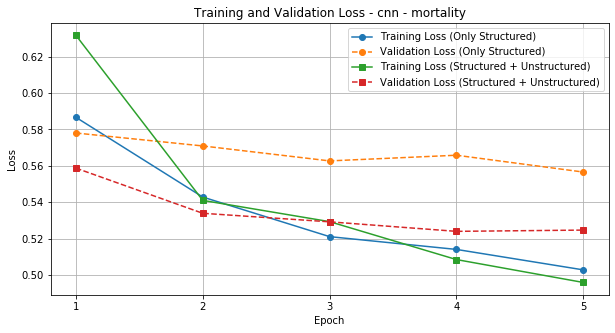

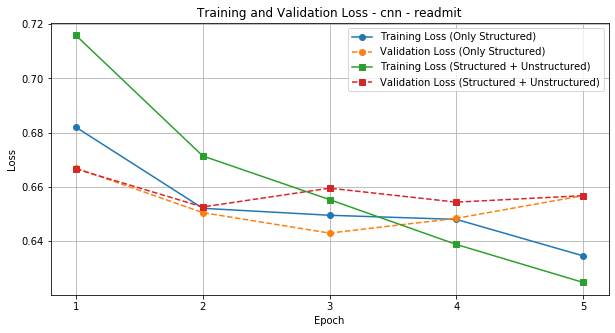

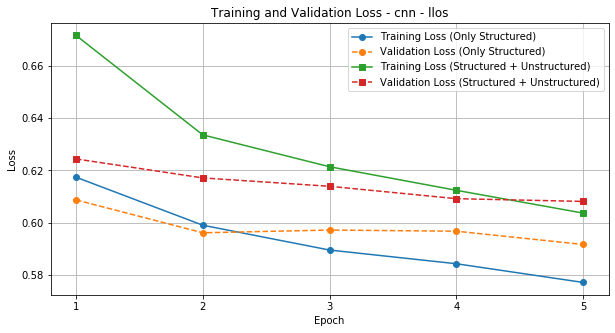

In [15]:
# Losses for Fusion-CNN
for task in list_tasks:
    plot_loss('cnn', task)


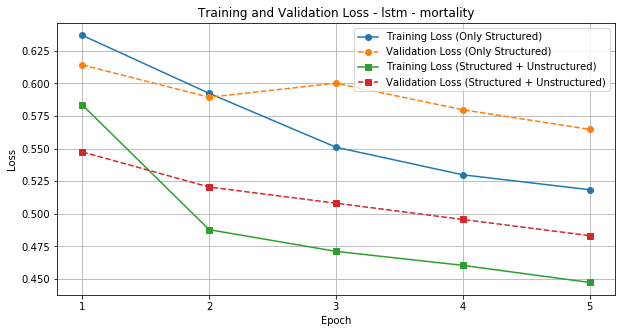

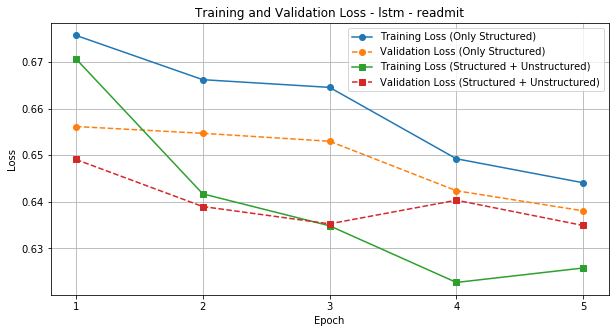

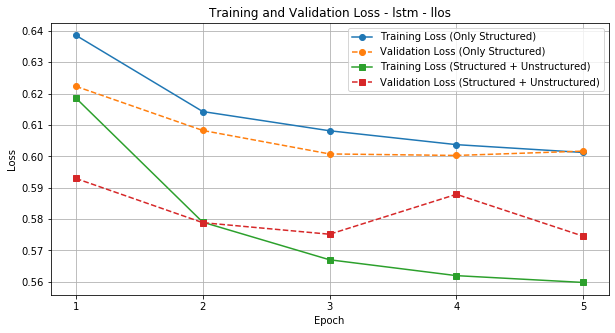

In [16]:
# Losses for Fusion-LSTM
for task in list_tasks:
    plot_loss('lstm', task)
    

## Testing AUCs

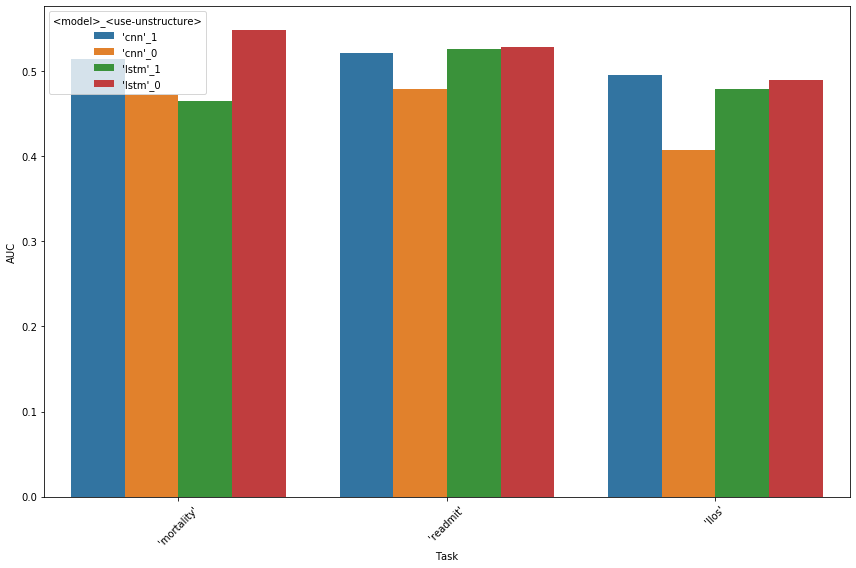

In [11]:
# Load dataframe with testing auc values
metrics_testing = pd.read_csv('./metrics/metrics_testing.csv')

# Create combinations of models, tasks, and datasets
metrics_testing['combination'] = metrics_testing['model'] + '_' + metrics_testing['use_unstructure'].astype(str)
metrics_testing['task_model_unstructure'] = metrics_testing['task'] + '_' + metrics_testing['combination']

# Plot bar graph
plt.figure(figsize=(12, 8))
sns.barplot(x='task', y='auc', hue='combination', data=metrics_testing)
plt.xticks(rotation=45)
plt.xlabel('Task')
plt.ylabel('AUC')
plt.legend(title='<model>_<use-unstructure>')
plt.tight_layout()
plt.show()


## Model comparison

* Fusion-CNN versus Fusion-LSTM
  * In-Hospital Mortality: Fusion-LSTM without unstructured data had the best test AUC with 0.55
  * 30-Day Readmission: Fusion-LSTM without unstructured data had the best test AUC with 0.53
  * Long Length of Stay: Fusion-CNN with unstructured data had the best test AUC with 0.50
* With unstructured versus without unstructured
  * With Fusion-CNNs, for each task, the additional of unstructured data improved the models' performances
  * With Fusion-LSTMs, for each task, the additional of unstructured data hurt the models' performances
* Deep Learning Models versus Baseline Models
  * From the results in the paper, the baseline models outperformed the deep learning models in this reproduction
  * In-Hospital Mortality: From the paper, logistic regression had the best test AUC with 0.86
  * 30-Day Readmission: From the paper, logistic regression had the best test AUC with 0.66
  * Long Length of Stay: From the paper, logistic regression had the best test AUC with 0.77


# Discussion

* **Make assessment that the paper is reproducible or not.**
  * This paper is reproducible. The initial results are negative. The deep learning models (Fusion-CNN and Fusion-LSTM) underperform on the testing data compared to the baseline models. However, the models have only been trained for 5 epochs due to time constaints. The paper trained the models for 50 epochs. The loss curves have not flattened out yet. With additional epochs, the results will likely be reproduced.
  
* **Describe “What was easy” and “What was difficult” during the reproduction.**
  * The code and the GitHub repository were well-documented and that made it easier for reproduction. It was easy to obtain the dataset and preprocess it for training the models. The structure of the models was easily understandable from the code. The old code/packages and porting the code to a Jupyter Notebook was difficult. It was difficult to create an environment that worked for the code, even with the specified package versions. I had to iterate with versions to get an environment that worked with my CUDA and GPU too. Also, I had to create a wrapper to initialize and train the models in a Jupyter notebook. These steps were difficult and took lots of time. 

* **Make suggestions to the author or other reproducers on how to improve the reproducibility.**
  * A suggestion to improve reproducibility would be to include an environment yml file for recreating the environment that worked with the code. Or having a Docker file would help with reproducibility as code gets older. I included a yml file for creating a Conda environment and would recommend that other reproducers use it for reproducing this paper.
* **What will you do in next phase.**
  * In the next phase, I will train the models for the 50 epochs specified in the paper and evaluate the results. Also, I will look into reproducing the baseline experiments with logistic regression and random forest.


# References

1. Zhang, D., Yin, C., Zeng, J., Yuan, X., & Zhang, P. (2020). Combining structured and unstructured data for predictive models: a deep learning approach. *BMC Medical Informatics and Decision Making*, *20*, 1-11.
2. Caruana, R., Lou, Y., Gehrke, J., Koch, P., Sturm, M., & Elhadad, N. (2015, August). Intelligible models for healthcare: Predicting pneumonia risk and hospital 30-day readmission. In *Proceedings of the 21th ACM SIGKDD International Conference on Knowledge Discovery and Data Mining* (pp. 1721-1730).
3. Tang, F., Xiao, C., Wang, F., & Zhou, J. (2018). Predictive modeling in urgent care: a comparative study of machine learning approaches. *JAMIA Open*, *1*(1), 87-98.
